## Import

In [20]:
import sys
sys.path.append(r'C:\Users\Marco\Documents\GitHub\GeoSpatial-analysis\facility-location-Bergen\src\facility_location_Bergen\custome_modules')

In [21]:
import warnings
from shapely.errors import ShapelyDeprecationWarning
# Ignore the ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

In [22]:
import io
import os
import json
import copy
import pytz
import folium
import pyproj
import requests
import numpy as np
import pandas as pd
import pickle as pkl
import datetime as dt
from PIL import Image
import networkx as nx
from time import time
import geopandas as gpd
import cartopy.crs as ccrs
from datetime import datetime
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import cartopy.io.img_tiles as cimgt
from shapely.geometry import MultiPoint
from urllib.request import urlopen, Request
from matplotlib.animation import FuncAnimation
from mongo_db import retrieve_database_and_collections
from networkx.drawing.nx_agraph import graphviz_layout
from convert_geometry import toMultiLineString, toExtremePoints
from log import print_INFO_message_timestamp, print_INFO_message
from retrieve_global_parameters import retrieve_gdf_average_path
from shapely.geometry import Point, MultiPoint, LineString, MultiLineString
from facility_location import AdjacencyMatrix, FacilityLocation, FacilityLocationReport

## Retrieve collection and convert to a dataframe

In [23]:
days = ["20_04_2023", "21_04_2023", "22_04_2023",
        "23_04_2023", "24_04_2023", "25_04_2023", 
        "26_04_2023", "27_04_2023", "28_04_2023",
        "29_04_2023", "30_04_2023"]

In [24]:
def get_gdf(day):
    with open(rf"C:\Users\Marco\Documents\GitHub\GeoSpatial-analysis\facility-location-Bergen\data\03_primary\{day}_processed.geojson", "rb") as f:
        gdf = pkl.load(f)
    return gdf

In [25]:
gdfs = [get_gdf(day) for day in days]

## Create the average graph

### Split data according to the time period

In [26]:
def get_time_gdf(gdf, time="morning"):
    first_morning_time = dt.time(5,30)
    last_morning_time = dt.time(7,30)
    first_midday_time = dt.time(9,0)
    last_midday_time = dt.time(10,0)
    first_afternoon_time = dt.time(13,0)
    last_afternoon_time = dt.time(15,0)
    
    if time == "morning":
        p1 = gdf["api_call_time"].dt.time >= first_morning_time
        p2 = gdf["api_call_time"].dt.time <= last_morning_time
        return gdf[p1 & p2]
    elif time == "midday":
        p1 = gdf["api_call_time"].dt.time >= first_midday_time
        p2 = gdf["api_call_time"].dt.time <= last_midday_time
        return gdf[p1 & p2]
    elif time == "afternoon":
        p1 = gdf["api_call_time"].dt.time >= first_afternoon_time
        p2 = gdf["api_call_time"].dt.time <= last_afternoon_time
        return gdf[p1 & p2]
    else:
        raise ValueError("time must be 'morning', 'midday' or 'afternoon'")
        

In [27]:
gdf = pd.concat(gdfs)

In [28]:
gdf_morning = get_time_gdf(gdf, time="morning")
gdf_midday = get_time_gdf(gdf, time="midday")
gdf_afternoon = get_time_gdf(gdf, time="afternoon")

In [29]:
def create_average_gdf(gdf):
   gdf_line = gdf.set_geometry("geometry.multi_line")
   gdf_point = gdf.set_geometry("geometry.extreme_point")
    
   gdf_line_average = gdf_line.groupby(["description", "geometry_length", "geometry.multi_line"], sort=False, dropna=False)[
       ['length', 'currentFlow.speed', 'currentFlow.speedUncapped',
       'currentFlow.freeFlow', 'currentFlow.jamFactor',
       'currentFlow.confidence']].mean().reset_index()
    
   gdf_point_average = gdf_point.groupby(["description", "geometry_length", "geometry.extreme_point"], sort=False, dropna=False)[
       ['length', 'currentFlow.speed', 'currentFlow.speedUncapped',
       'currentFlow.freeFlow', 'currentFlow.jamFactor',
       'currentFlow.confidence']].mean().reset_index()
    
   gdf_average = copy.deepcopy(gdf_point_average)
   gdf_average["geometry.multi_line"] = gdf_line_average["geometry.multi_line"]
    
   gdf_average = gdf_average[['description','geometry_length', 'geometry.extreme_point', 'geometry.multi_line', 
                              'length', 'currentFlow.speed', 'currentFlow.speedUncapped', 'currentFlow.freeFlow',
                              'currentFlow.jamFactor', 'currentFlow.confidence',]]
    
   return gdf_average

In [30]:
def take_average_worst_case_gdf(gdf):
    gdf = gdf[gdf["currentFlow.traversability"] == "open"]
   
    gdf["hours_minutes_seconds"] = gdf.apply(lambda x: x["api_call_time"].time(), axis=1)
   
    gdf["geometry_length"] = gdf["geometry_length"].apply(lambda x: tuple(x) if type(x) == list else tuple([x]))
    gdf_line = gdf.set_geometry("geometry.multi_line")
    gdf_point = gdf.set_geometry("geometry.extreme_point")
    
    gdf_line_worst = gdf_line.groupby(["description", "geometry_length", "geometry.multi_line", "hours_minutes_seconds"], sort=False, dropna=False)[
       ['length', 'currentFlow.speed', 'currentFlow.speedUncapped',
       'currentFlow.freeFlow', 'currentFlow.jamFactor',
       'currentFlow.confidence']].max().reset_index()
    
    gdf_point_worst = gdf_point.groupby(["description", "geometry_length", "geometry.extreme_point", "hours_minutes_seconds"], sort=False, dropna=False)[
       ['length', 'currentFlow.speed', 'currentFlow.speedUncapped',
       'currentFlow.freeFlow', 'currentFlow.jamFactor',
       'currentFlow.confidence']].max().reset_index()
    
    gdf_worst = copy.deepcopy(gdf_point_worst)
    gdf_worst["geometry.multi_line"] = gdf_line_worst["geometry.multi_line"]
    
    gdf_worst = gdf_worst[['description','geometry_length', 'geometry.extreme_point', 'geometry.multi_line', 
                              'length', 'currentFlow.speed', 'currentFlow.speedUncapped', 'currentFlow.freeFlow',
                              'currentFlow.jamFactor', 'currentFlow.confidence', "hours_minutes_seconds"]]
    
    gdf_worst_average = create_average_gdf(gdf_worst)
    
    return gdf_worst_average

In [31]:
gdf_worst_average = take_average_worst_case_gdf(gdf)

[05/30/23 19:11:58] WARNING  C:\Users\Marco\AppData\Local\Temp\ipykernel_41368\820592101.py:4:      warnings.py:109
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               gdf["hours_minutes_seconds"] = gdf.apply(lambda x:                                  
                             x["api_call_time"].time(), axis=1)                                                    
                                                                                                                   

                    WARNING  C:\Users\Marco\AppData\Local\Temp\ipykernel_41368\820592101.py:6:      warnings.py:109
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               gdf["geometry_length"] = gdf["geometry_length"].apply(lambda x:                     
                             tuple(x) if type(x) == list else tuple([x]))                                          
                                                                                                                   

In [32]:
gdf_morning_worst_average = take_average_worst_case_gdf(gdf_morning)
gdf_midday_worst_average = take_average_worst_case_gdf(gdf_midday)
gdf_afternoon_worst_average = take_average_worst_case_gdf(gdf_afternoon)

[05/30/23 19:14:52] WARNING  C:\Users\Marco\AppData\Local\Temp\ipykernel_41368\820592101.py:4:      warnings.py:109
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               gdf["hours_minutes_seconds"] = gdf.apply(lambda x:                                  
                             x["api_call_time"].time(), axis=1)                                                    
                                                                                                                   

[05/30/23 19:14:53] WARNING  C:\Users\Marco\AppData\Local\Temp\ipykernel_41368\820592101.py:6:      warnings.py:109
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               gdf["geometry_length"] = gdf["geometry_length"].apply(lambda x:                     
                             tuple(x) if type(x) == list else tuple([x]))                                          
                                                                                                                   

[05/30/23 19:15:28] WARNING  C:\Users\Marco\AppData\Local\Temp\ipykernel_41368\820592101.py:4:      warnings.py:109
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               gdf["hours_minutes_seconds"] = gdf.apply(lambda x:                                  
                             x["api_call_time"].time(), axis=1)                                                    
                                                                                                                   

                    WARNING  C:\Users\Marco\AppData\Local\Temp\ipykernel_41368\820592101.py:6:      warnings.py:109
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               gdf["geometry_length"] = gdf["geometry_length"].apply(lambda x:                     
                             tuple(x) if type(x) == list else tuple([x]))                                          
                                                                                                                   

[05/30/23 19:15:48] WARNING  C:\Users\Marco\AppData\Local\Temp\ipykernel_41368\820592101.py:4:      warnings.py:109
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               gdf["hours_minutes_seconds"] = gdf.apply(lambda x:                                  
                             x["api_call_time"].time(), axis=1)                                                    
                                                                                                                   

                    WARNING  C:\Users\Marco\AppData\Local\Temp\ipykernel_41368\820592101.py:6:      warnings.py:109
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               gdf["geometry_length"] = gdf["geometry_length"].apply(lambda x:                     
                             tuple(x) if type(x) == list else tuple([x]))                                          
                                                                                                                   

In [33]:
gdfs_average = {"all_day": gdf_worst_average, "morning": gdf_morning_worst_average, "midday": gdf_midday_worst_average, "afternoon": gdf_afternoon_worst_average}

### Visualize the data

In [34]:
def image_spoof(self, tile): # this function pretends not to be a Python script
    url = self._image_url(tile) # get the url of the street map API
    req = Request(url) # start request
    req.add_header('User-agent','Anaconda 3') # add user agent to request
    fh = urlopen(req) 
    im_data = io.BytesIO(fh.read()) # get image
    fh.close() # close url
    img = Image.open(im_data) # open image with PIL
    img = img.convert(self.desired_tile_form) # set image format
    return img, self.tileextent(tile), 'lower' # reformat for cartopy

In [35]:
cimgt.OSM.get_image = image_spoof # reformat web request for street map spoofing
osm_img = cimgt.OSM() # spoofed, downloaded street map

In [36]:
def get_color(jam):
    if jam is np.nan:
        return np.nan
    
    if 0 <= jam <= 3:
        return "green"
    elif 3 < jam <= 7:
        return "orange"
    elif 7 <= jam <= 10:
        return "red"

In [37]:
def prepare_gdf_to_plot(gdf_average):
    lats = {}
    lons = {}
    df_list = []
    
    for feature, jam in zip(gdf_average['geometry.multi_line'], gdf_average["currentFlow.jamFactor"]):
        color = get_color(jam)
        linestrings = feature.geoms
        lats = []
        lons = []
        colors = []
        
        for linestring in linestrings:
            x, y = linestring.xy
            lats = np.append(lats, list(x))
            lons = np.append(lons, list(y))
            colors = np.append(colors, [color]*len(x))
        
        df_list.append(pd.DataFrame({"lat": lats, "lon": lons, "color": colors}))
        df_list[-1] = pd.concat([df_list[-1], 
                                       pd.DataFrame({"lat": [np.nan], "lon": [np.nan], "color": [np.nan]})],
                                      ignore_index=True)

    df = pd.concat(df_list, ignore_index=True)
    return df

In [38]:
gdf_plot = [prepare_gdf_to_plot(df) for df in gdfs_average.values()]

[05/30/23 19:43:59] INFO     Start plotting...
                    INFO     plot 1 of 4
                    INFO     plot 2 of 4
                    INFO     plot 3 of 4
                    INFO     plot 4 of 4
[05/30/23 19:47:05] INFO     Saving figure...


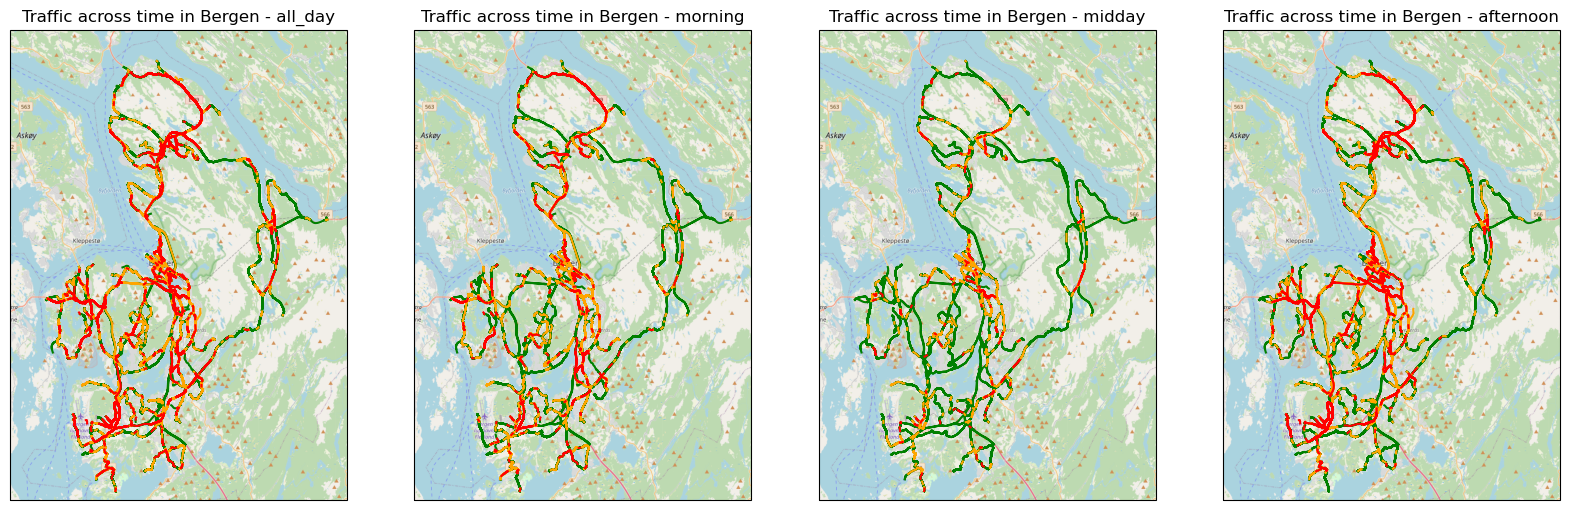

In [39]:
fig, ax = plt.subplots(figsize=(20, 20), ncols=4, nrows=1, subplot_kw={'projection': osm_img.crs})

print_INFO_message_timestamp("Start plotting...")

for i, gdf in enumerate(gdf_plot):
    print_INFO_message(f"plot {i+1} of {len(gdf_plot)}")
    center_pt = [60.39299, 5.32415] # lat/lon of One World Trade Center in NYC
    zoom = 0.15 # for zooming out of center point
    extent = [center_pt[1]-(zoom*1.3),center_pt[1]+(zoom*1.6),center_pt[0]-zoom,center_pt[0]+zoom] # adjust to zoom
        
    ax[i].set_extent(extent) # set extents

    scale = np.ceil(-np.sqrt(2)*np.log(np.divide(zoom,350.0))) # empirical solve for scale based on zoom
    scale = (scale<20) and scale or 19 # scale cannot be larger than 19
    ax[i].add_image(osm_img, int(scale))

    ax[i].set_title(f'Traffic across time in Bergen - {list(gdfs_average.keys())[i]}')

    ax[i].plot('lat', 'lon', data=gdf.where(gdf.color=="green"), c="green", transform=ccrs.Geodetic())
    ax[i].plot('lat', 'lon', data=gdf.where(gdf.color=="orange"), c="orange", transform=ccrs.Geodetic())
    ax[i].plot('lat', 'lon', data=gdf.where(gdf.color=="red"), c="red", transform=ccrs.Geodetic())

print_INFO_message_timestamp("Saving figure...")
fig.savefig("prova.png")

### Keep only data common to all time periods

In [40]:
for df in gdfs_average.values():
    print_INFO_message(f"shape: {df.shape[0]-len(df['geometry.multi_line'].unique())}")

                    INFO     shape: 4
                    INFO     shape: 4
                    INFO     shape: 4
                    INFO     shape: 4


In [41]:
def merge_average_gdf(gdfs_average):
    keys = list(gdfs_average.keys())
    gdf_merge = gdfs_average[keys[0]][["description", "geometry_length", "geometry.extreme_point"]]\
        .merge(gdfs_average[keys[1]][["description", "geometry_length", "geometry.extreme_point"]],\
            how="inner", on=["description", "geometry_length", "geometry.extreme_point"])
    for i in range(2, len(keys)):
        try:
            gdf_merge = gdf_merge.merge(gdfs_average[keys[i]][["description", "geometry_length", "geometry.extreme_point"]],\
                how="inner", on=["description", "geometry_length", "geometry.extreme_point"])
        except:
            print_INFO_message(f"Could not merge {keys[i]}")
            return gdf_merge
    return gdf_merge

In [42]:
gdf_merge = merge_average_gdf(gdfs_average)

In [43]:
gdf_merge

,description,geometry_length,geometry.extreme_point
0,Herland,"(21.0, 60.0, 26.0, 93.0, 14.0, 17.0, 79.0, 64.0)","MULTIPOINT (5.53747 60.42335, 5.53903 60.42214)"
1,Herland,"(134.0, 93.0, 26.0, 60.0)","MULTIPOINT (5.53492 60.42177, 5.53757 60.42317)"
2,Takvam,"(59.0, 33.0, 803.0, 66.0, 58.0, 40.0, 70.0, 33...","MULTIPOINT (5.53492 60.42177, 5.51596 60.42212)"
3,Takvam,"(19.0, 12.0)","MULTIPOINT (5.51612 60.42207, 5.51624 60.42231)"
4,Takvam,"(37.0, 52.0, 37.0, 15.0, 68.0, 13.0, 61.0, 21....","MULTIPOINT (5.46050 60.42195, 5.51596 60.42212)"
...,...,...,...
1675,Skulehaugen,"(19.0, 385.0, 77.0, 123.0, 114.0, 19.0, 14.0, ...","MULTIPOINT (5.28823 60.34133, 5.28176 60.34838)"
1676,Nygård,"(30.0, 16.0, 38.0, 40.0)","MULTIPOINT (5.29316 60.38782, 5.29176 60.38869)"
1677,Busstasjonen,"(56.0, 51.0, 19.0, 30.0, 48.0, 74.0)","MULTIPOINT (5.33387 60.38715, 5.33119 60.38925)"
1678,Sædalstunnelen,"(122.0,)","MULTIPOINT (5.38854 60.34512, 5.38667 60.34455)"


In [44]:
gdfs_average_merged = {}

for key in gdfs_average.keys():
    gdfs_average_merged[key] = gdfs_average[key].merge(gdf_merge, how="inner", on=["description", "geometry_length", "geometry.extreme_point"])

In [49]:
gdf_plot = [prepare_gdf_to_plot(df) for df in gdfs_average_merged.values()]

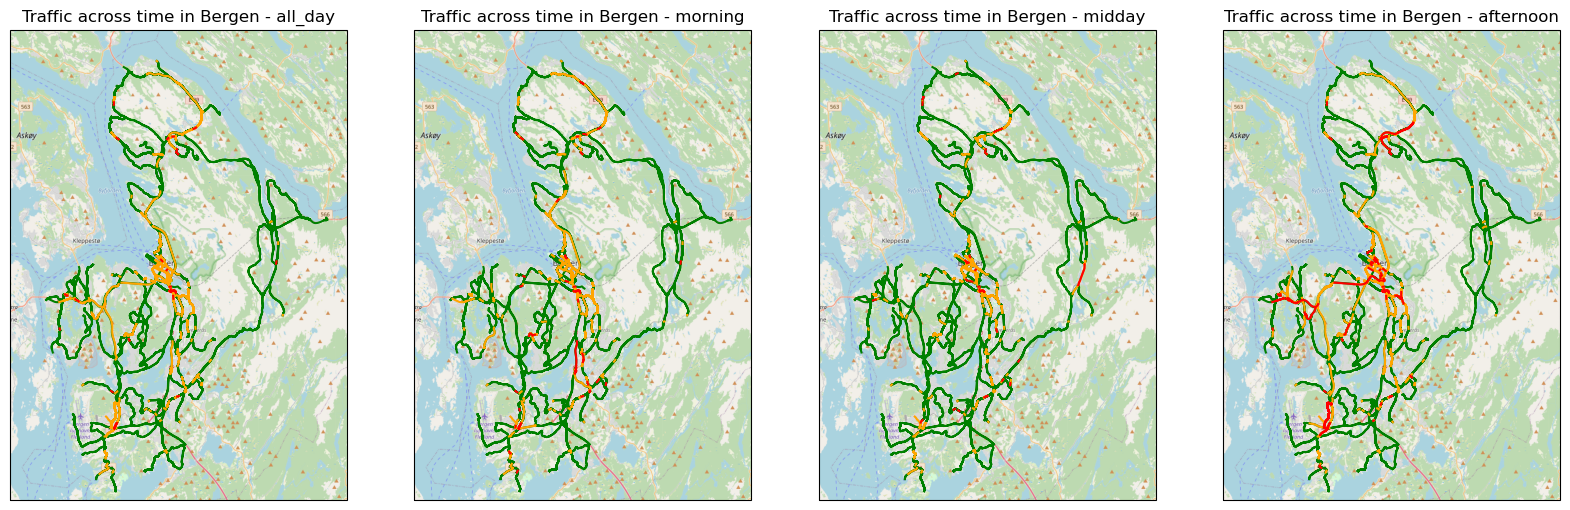

In [50]:
fig, ax = plt.subplots(figsize=(20, 20), ncols=4, nrows=1, subplot_kw={'projection': osm_img.crs})

for i, gdf in enumerate(gdf_plot):
    center_pt = [60.39299, 5.32415] # lat/lon of One World Trade Center in NYC
    zoom = 0.15 # for zooming out of center point
    extent = [center_pt[1]-(zoom*1.3),center_pt[1]+(zoom*1.6),center_pt[0]-zoom,center_pt[0]+zoom] # adjust to zoom
        
    ax[i].set_extent(extent) # set extents

    scale = np.ceil(-np.sqrt(2)*np.log(np.divide(zoom,350.0))) # empirical solve for scale based on zoom
    scale = (scale<20) and scale or 19 # scale cannot be larger than 19
    ax[i].add_image(osm_img, int(scale))

    ax[i].set_title(f'Traffic across time in Bergen - {["all_day", "morning", "midday", "afternoon"][i]}')

    ax[i].plot('lat', 'lon', data=gdf.where(gdf.color=="green"), c="green", transform=ccrs.Geodetic())
    ax[i].plot('lat', 'lon', data=gdf.where(gdf.color=="orange"), c="orange", transform=ccrs.Geodetic())
    ax[i].plot('lat', 'lon', data=gdf.where(gdf.color=="red"), c="red", transform=ccrs.Geodetic())
